# Andrii Shevtsov homework 3, IASA NLP

## Imports and constants

In [22]:
!pip install optuna

In [1]:
import re

import gensim
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import optuna

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.stats import pearsonr, spearmanr, ttest_ind, levene

In [47]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
DISASTERS_TRAIN_FILE = '../../data/nlp_getting_started/train.csv'
DISASTERS_TEST_FILE = '../../data/nlp_getting_started/test.csv'

SUMMARIES_TRAIN_FILE = '../../data/commonlit_evaluate_student_summaries/summaries_train.csv'
SUMMARIES_TEST_FILE = '../../data/commonlit_evaluate_student_summaries/summaries_test.csv'
PROMPTS_TRAIN_FILE = '../../data/commonlit_evaluate_student_summaries/prompts_train.csv'
PROMPTS_TEST_FILE = '../../data/commonlit_evaluate_student_summaries/prompts_test.csv'

## Natural Language Processing with Disaster Tweets

### Validation consistency

In the original problem, there is a simple random train/test split, so we will also make some random ungrouped splits and see the tresults.

In [13]:
df_twitter_train = pd.read_csv(DISASTERS_TRAIN_FILE, index_col='id')
df_twitter_test = pd.read_csv(DISASTERS_TEST_FILE, index_col='id')

df_twitter_train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [26]:
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'good', 'bad', 'people']) #stopwords extended a bit

def preprocess(text, join_back=True, stemmer = PorterStemmer()):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and 
            token not in stop_words
        ):
            result.append(token)
    
    result = [stemmer.stem(word) for word in result]
    if join_back:
        result = " ".join(result)
    
    return result

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
create_full_text = lambda row: row['text'] + ' ' + (str(row['keyword']) if not pd.isnull(row['keyword']) else '') + ' ' + (str(row['location']) if not pd.isnull(row['location']) else '')

df_twitter_train['text_full'] = df_twitter_train.apply(create_full_text, axis=1)
df_twitter_test['text_full'] = df_twitter_test.apply(create_full_text, axis=1)

df_twitter_train['text_clean'] = df_twitter_train['text_full'].apply(preprocess)
df_twitter_test['text_clean'] = df_twitter_test['text_full'].apply(preprocess)

df_twitter_train.head()

,keyword,location,text,target,text_clean,text_full
id,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak allah forgiv,Our Deeds are the Reason of this #earthquake M...
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest near la rong sask canada,Forest fire near La Ronge Sask. Canada
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,All residents asked to 'shelter in place' are ...
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,receiv wildfir evacu order california,"13,000 people receive #wildfires evacuation or..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,Just got sent this photo from Ruby #Alaska as ...


In [80]:
classifiers = {
    "logistic_regression": Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=5,
        max_features=30000
    )),  
    ('classifier', LogisticRegression())
]),
    "support_vector_machine": Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=5,
        max_features=30000
    )),  
    ('classifier', LinearSVC(dual="auto"))
]),
    "decision_tree": Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=5,
        max_features=30000
    )),  
    ('classifier', DecisionTreeClassifier())
])
              }

Let's compare three methods: holdout set, k-fold and stratified K-fold.

#### Holdout set

In [81]:
X_train, y_train = df_twitter_train['text_clean'], df_twitter_train['target']
X_test = df_twitter_test['text_clean']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [87]:
for pipe_name, pipe in classifiers.items():
    pipe.fit(X_train, y_train)
    train_score = f1_score(y_train, pipe.predict(X_train))
    val_score = f1_score(y_val, pipe.predict(X_val))
    
    y_test_pred = pipe.predict(X_test)
    df_submission = df_twitter_test.copy()
    df_submission['target'] = y_test_pred
    df_submission.loc[:, ['target']].to_csv(f'./submissions/submission_{pipe_name}_holdout.csv')
    
    print(f"Holdout set, classifier {pipe_name}:\n\tTrain F1 = {train_score:.4f}\n\tVal F1  = {val_score:.4f}")

Holdout set, classifier logistic_regression:
	Train F1 = 0.8152
	Val F1  = 0.7481
Holdout set, classifier support_vector_machine:
	Train F1 = 0.8875
	Val F1  = 0.7377
Holdout set, classifier decision_tree:
	Train F1 = 0.9896
	Val F1  = 0.6796


#### 5-fold CV

In [104]:
cv = KFold(n_splits=5, shuffle=True)

In [105]:
for pipe_name, pipe in classifiers.items():
    val_scores = cross_val_score(pipe, df_twitter_train['text_clean'], df_twitter_train['target'], cv=cv, scoring='f1')
    
    pipe.fit(df_twitter_train['text_clean'], df_twitter_train['target'])
    
    y_test_pred = pipe.predict(X_test)
    df_submission = df_twitter_test.copy()
    df_submission['target'] = y_test_pred
    df_submission.loc[:, ['target']].to_csv(f'./submissions/submission_{pipe_name}_kfold.csv')

    print(f"K Fold, classifier {pipe_name}:\n\tMean val F1  = {(val_scores).mean():.4f}")

K Fold, classifier logistic_regression:
	Mean val F1  = 0.7478
K Fold, classifier support_vector_machine:
	Mean val F1  = 0.7328
K Fold, classifier decision_tree:
	Mean val F1  = 0.6542


#### Stratified 5-fold CV

We don't save submissions here, because they are the same as for the simple KFold

In [106]:
cv_strat = StratifiedKFold(n_splits=5, shuffle=True)

In [107]:
for pipe_name, pipe in classifiers.items():
    val_scores = cross_val_score(pipe, df_twitter_train['text_clean'], df_twitter_train['target'], cv=cv_strat, scoring='f1')
    print(f"Stratified K Fold, classifier {pipe_name}:\n\tMean val F1  = {(val_scores).mean():.4f}")

Stratified K Fold, classifier logistic_regression:
	Mean val F1  = 0.7411
Stratified K Fold, classifier support_vector_machine:
	Mean val F1  = 0.7407
Stratified K Fold, classifier decision_tree:
	Mean val F1  = 0.6578


#### Results

Scores look like the following:

![Scores for these submissions](./images/submissions_disaster_tweets.png)

Let's draw a plot of evaluation / leaderboard score: 

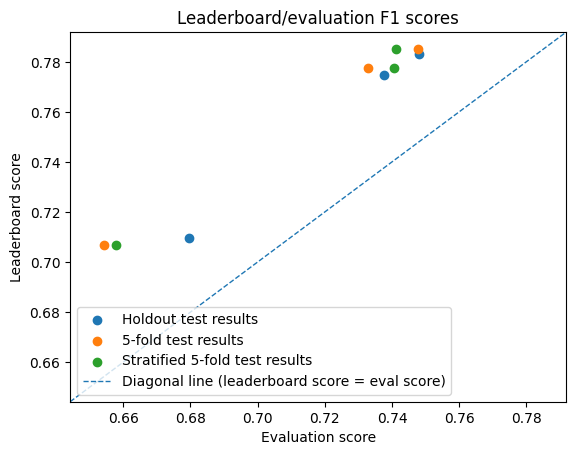

In [4]:
plt.scatter([0.7481, 0.7377, 0.6796], [0.78302, 0.77474, 0.70977], label="Holdout test results")
plt.scatter([0.7478, 0.7328, 0.6542], [0.78516, 0.7775, 0.70671], label="5-fold test results")
plt.scatter([0.7411, 0.7407, 0.6578], [0.78516, 0.7775, 0.70671], label="Stratified 5-fold test results")


plt.xlabel("Evaluation score")
plt.ylabel("Leaderboard score")
plt.title("Leaderboard/evaluation F1 scores")

plt.axline((0.6509, 0.6509), (0.78516, 0.78516), linestyle="--", linewidth=1, label="Diagonal line (leaderboard score = eval score)")

plt.legend()

plt.show()

Evaluation score definitely correlates with its leaderboard mate, but it is definitely a little bit lower for all the pipelines and evaluations.

Probably it is the case because actually competition uses the macro F1, not simply F1 for the positive label.

Let's try it:

In [98]:
for pipe_name, pipe in classifiers.items():
    pipe.fit(X_train, y_train)
    train_score = f1_score(y_train, pipe.predict(X_train), average='macro')
    val_score = f1_score(y_val, pipe.predict(X_val), average='macro')
    
    print(f"Holdout set, classifier {pipe_name}:\n\tTrain F1 = {train_score:.4f}\n\tVal F1  = {val_score:.4f}")

Holdout set, classifier logistic_regression:
	Train F1 = 0.8456
	Val F1  = 0.7910
Holdout set, classifier support_vector_machine:
	Train F1 = 0.9039
	Val F1  = 0.7789
Holdout set, classifier decision_tree:
	Train F1 = 0.9909
	Val F1  = 0.7162


In [111]:
for pipe_name, pipe in classifiers.items():
    val_scores = cross_val_score(pipe, df_twitter_train['text_clean'], df_twitter_train['target'], cv=cv, 
                                 scoring=make_scorer(f1_score, average='macro'))
    print(f"K Fold, classifier {pipe_name}:\n\tMean val macro F1  = {(val_scores).mean():.4f}")

K Fold, classifier logistic_regression:
	Mean val macro F1  = 0.7814
K Fold, classifier support_vector_machine:
	Mean val macro F1  = 0.7787
K Fold, classifier decision_tree:
	Mean val macro F1  = 0.7057


In [112]:
for pipe_name, pipe in classifiers.items():
    val_scores = cross_val_score(pipe, df_twitter_train['text_clean'], df_twitter_train['target'], cv=cv_strat, 
                                 scoring=make_scorer(f1_score, average='macro'))
    print(f"Stratified K Fold, classifier {pipe_name}:\n\tMean val F1  = {(val_scores).mean():.4f}")

Stratified K Fold, classifier logistic_regression:
	Mean val F1  = 0.7832
Stratified K Fold, classifier support_vector_machine:
	Mean val F1  = 0.7728
Stratified K Fold, classifier decision_tree:
	Mean val F1  = 0.6999


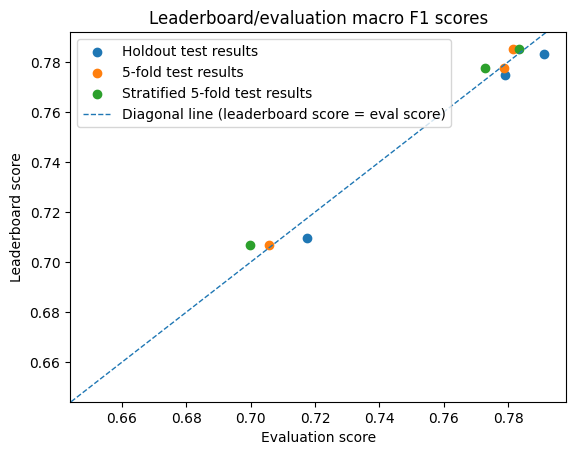

In [3]:
plt.scatter([0.7910, 0.7789, 0.7175], [0.78302, 0.77474, 0.70977], label="Holdout test results")
plt.scatter([0.7814, 0.7787, 0.7057], [0.78516, 0.7775, 0.70671], label="5-fold test results")
plt.scatter([0.7832, 0.7728, 0.6999], [0.78516, 0.7775, 0.70671], label="Stratified 5-fold test results")


plt.xlabel("Evaluation score")
plt.ylabel("Leaderboard score")
plt.title("Leaderboard/evaluation macro F1 scores")

plt.axline((0.6509, 0.6509), (0.78516, 0.78516), linestyle="--", linewidth=1, label="Diagonal line (leaderboard score = eval score)")

plt.legend()

plt.show()

Here, we can clearly see that k fold is the best one predictive for such random initialization. But, actually, all methods are pretty accurate on the task and evaluation correlates with the leaderboard.

### Adversarial validation

In [120]:
df_adversarial = pd.concat([df_twitter_train, df_twitter_test]).reset_index()
df_adversarial.loc[:, 'target'] = len(df_twitter_train)*[0] + len(df_twitter_test)*[1]

X_train_adv, X_val_adv, y_train_adv, y_val_adv = train_test_split(
    df_adversarial['text_clean'], df_adversarial['target'], stratify=df_adversarial['target'], test_size=0.2
)

for pipe_name, pipe in classifiers.items():
    pipe.fit(X_train_adv, y_train_adv)
    
    y_train_pred = pipe_classification.predict(X_train_adv)
    y_val_pred = pipe_classification.predict(X_val_adv)
    
    train_score = f1_score(y_train_adv, y_train_pred, average='macro')
    val_score = f1_score(y_val_adv, y_val_pred, average='macro')
    val_roc_auc = roc_auc_score(y_val_adv, pipe_classification.predict_proba(X_val_adv)[:, 1])
    
    print(f"Classifier {pipe_name}:\n\tTrain macro F1 = {train_score:.4f}\n\tVal macro F1  = {val_score:.4f}")
    print(f"\tVal ROC AUC = {val_roc_auc}")

Classifier logistic_regression:
	Train macro F1 = 0.4653
	Val macro F1  = 0.4251
	Val ROC AUC = 0.5032025531940566
Classifier support_vector_machine:
	Train macro F1 = 0.4653
	Val macro F1  = 0.4251
	Val ROC AUC = 0.5032025531940566
Classifier decision_tree:
	Train macro F1 = 0.4653
	Val macro F1  = 0.4251
	Val ROC AUC = 0.5032025531940566


In [116]:
print("Percent of test:", len(df_twitter_test)/len(df_adversarial))

Percent of test: 0.3000183891136447


Confusion matrix for such a classifier, if it can't find any leaks, should look like:

|                   | Test     | Train     |
| ----------------: | :------: | :-------: |
| Test              | 0.3 * 0.3 = 0.09 | 0.3 * 0.7 = 0.21 |
| Train             | 0.7 * 0.3 = 0.21 | 0.7 * 0.7 = 0.49 |

For the test class, F1 should be 2\*0.09/(2\*0.09 + 0.21 + 0.21) = 0.3

For the train class, F1 should be 2\*0.49/(2\*0.49 + 0.21 + 0.21) = 0.7

So, for completely independent classes macro F1 should be (0.3 + 0.7) / 2 = 0.5

Macro F1 is smaller in our case, so there are clearly no leaks.

ROC AUC score also shows that we have completely randomized predictions.

## CommonLit - Evaluate Student Summaries

### Preparation

It is heavily based on the previous home task, but there are some changes and simplifications

In [3]:
summaries_train_df = pd.read_csv(SUMMARIES_TRAIN_FILE)
summaries_test_df = pd.read_csv(SUMMARIES_TEST_FILE)
prompts_train_df = pd.read_csv(PROMPTS_TRAIN_FILE)
prompts_test_df = pd.read_csv(PROMPTS_TEST_FILE)

In [4]:
summaries_train_df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [5]:
stop_words = list(STOPWORDS)
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'good', 'bad', 'people']) #stopwords extended a bit
def preprocess_hard_base(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Stop Words Cleaning
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and 
            token not in stop_words
        ):
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result

In [6]:
def preprocess_hard_stemming(text, join_back=True, stemmer = PorterStemmer()):
    tokens = preprocess_hard_base(text, join_back=False)
    
    result = [stemmer.stem(word) for word in tokens]
    if join_back:
        result = " ".join(result)
    
    return result

In [7]:
def collapse_dots(text):
    # Collapse sequential dots
    input = re.sub("\.+", ".", text)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", text)
        all_collapsed = input == output
        input = output
    return output

# Check how it will influence different ML models
def process_soft(text):
    if isinstance(text, str):
        text = " ".join(tokenize.sent_tokenize(text))
        text = re.sub(r"http\S+", "", text)
        text = re.sub(r"\n+", ". ", text)
        for symb in ["!", ",", ":", ";", "?"]:
            text = re.sub(rf"\{symb}\.", symb, text)
        text = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", text)
        text = re.sub(r"#\S+", "", text)
        text = collapse_dots(text)
        text = text.strip()
    return text

In [11]:
prompts_train_df['prompt_question_hard_preprocessed_stemmed'] = prompts_train_df['prompt_question'].apply(preprocess_hard_stemming)
prompts_train_df['prompt_title_hard_preprocessed_stemmed'] = prompts_train_df['prompt_title'].apply(preprocess_hard_stemming)
prompts_train_df['prompt_text_hard_preprocessed_stemmed'] = prompts_train_df['prompt_text'].apply(preprocess_hard_stemming)

prompts_train_df['prompt_question_soft_preprocessed'] = prompts_train_df['prompt_question'].apply(process_soft)
prompts_train_df['prompt_title_soft_preprocessed'] = prompts_train_df['prompt_title'].apply(process_soft)
prompts_train_df['prompt_text_soft_preprocessed'] = prompts_train_df['prompt_text'].apply(process_soft)

prompts_train_df

,prompt_id,prompt_question,prompt_title,prompt_text,prompt_question_hard_preprocessed_stemmed,prompt_title_hard_preprocessed_stemmed,prompt_text_hard_preprocessed_stemmed,prompt_question_soft_preprocessed,prompt_title_soft_preprocessed,prompt_text_soft_preprocessed
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,summar element ideal tragedi describ aristotl,tragedi,chapter sequel said proceed consid poet aim av...,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 . As the sequel to what has already...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,complet sentenc summar structur ancient egypti...,egyptian social structur,egyptian societi structur pyramid god ra osiri...,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,summar wave develop short period time experi end,wave,background wave experi took place cubberley hi...,Summarize how the Third Wave developed over su...,The Third Wave,Background . The Third Wave experiment took pl...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",summar way factori cover spoil meat cite evid ...,excerpt jungl,member trim beef canneri work sausag factori f...,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [15]:
summaries_train_df['text_hard_preprocessed_stemmed'] = summaries_train_df['text'].apply(preprocess_hard_stemming)
summaries_train_df['text_soft_preprocessed'] = summaries_train_df['text'].apply(process_soft)

summaries_test_df['text_hard_preprocessed_stemmed'] = summaries_test_df['text'].apply(preprocess_hard_stemming)
summaries_test_df['text_soft_preprocessed'] = summaries_test_df['text'].apply(process_soft)

summaries_train_df

,student_id,prompt_id,text,content,wording,text_hard_preprocessed_stemmed,text_hard_preprocessed_stemmed_word_cnt,text_hard_preprocessed_stemmed_length,text_soft_preprocessed
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,wave experimentto react new leader govern gain...,28,173,The third wave was an experimentto see how peo...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,rub soda smell away wouldnt smell meat toss fl...,14,80,They would rub it up with soda to make the sme...
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,egypt occup social class involv day day live i...,98,623,"In Egypt, there were many occupations and soci..."
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,highest class pharaoh god nd highest class gon...,14,89,The highest class was Pharaohs these people we...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,wave develop rapidli student genuinli believ b...,88,586,The Third Wave developed rapidly because the s...
...,...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538,sort chemic concoct meat fine shown quot mirac...,25,149,They used all sorts of chemical concoctions to...
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171,lowest class slave farmer slave taken war farm...,23,153,The lowest classes are slaves and farmers slav...
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603,sorta start work structour they barley got pai...,25,149,they sorta made people start working on the st...
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128,ideal trageti element ideal start great traged...,26,155,An ideal tragety has three elements that make ...


In [13]:
# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stop_words)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text.
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

# This function applies all the above preprocessing functions on a text feature.
def streamlit_feature_engineer(dataframe: pd.DataFrame, feature: str = 'text', preprocessed_hard: bool = False) -> pd.DataFrame:
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    if not preprocessed_hard:
        dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
        dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
        dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [18]:
summaries_train_df = streamlit_feature_engineer(summaries_train_df, feature = "text_hard_preprocessed_stemmed", preprocessed_hard=True)
summaries_train_df = streamlit_feature_engineer(summaries_train_df, feature = "text_soft_preprocessed")

summaries_test_df = streamlit_feature_engineer(summaries_test_df, feature = "text_hard_preprocessed_stemmed", preprocessed_hard=True)
summaries_test_df = streamlit_feature_engineer(summaries_test_df, feature = "text_soft_preprocessed")

In [19]:
summaries_train_df.head()

,student_id,prompt_id,text,content,wording,text_hard_preprocessed_stemmed,text_hard_preprocessed_stemmed_word_cnt,text_hard_preprocessed_stemmed_length,text_soft_preprocessed,text_soft_preprocessed_word_cnt,text_soft_preprocessed_length,text_soft_preprocessed_stopword_cnt,text_soft_preprocessed_punct_cnt,text_soft_preprocessed_number_cnt
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,wave experimentto react new leader govern gain...,28,173,The third wave was an experimentto see how peo...,61,346,28,3,0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,rub soda smell away wouldnt smell meat toss fl...,14,80,They would rub it up with soda to make the sme...,52,244,34,2,0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,egypt occup social class involv day day live i...,98,623,"In Egypt, there were many occupations and soci...",235,1370,116,38,0
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,highest class pharaoh god nd highest class gon...,14,89,The highest class was Pharaohs these people we...,25,157,12,6,2
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,wave develop rapidli student genuinli believ b...,88,586,The Third Wave developed rapidly because the s...,203,1222,98,30,3


In [20]:
prompts_ids_to_is = {prompt_id: i for i, prompt_id in zip(prompts_train_df.index, prompts_train_df['prompt_id'])}
summaries_train_df['prompt_i'] = summaries_train_df['prompt_id'].apply(lambda prompt_id: prompts_ids_to_is[prompt_id])
prompts_ids_to_is_test = {prompt_id: i for i, prompt_id in zip(prompts_test_df.index, prompts_test_df['prompt_id'])}
summaries_test_df['prompt_i'] = summaries_test_df['prompt_id'].apply(lambda prompt_id: prompts_ids_to_is_test[prompt_id])
summaries_test_df.head()

,student_id,prompt_id,text,text_hard_preprocessed_stemmed,text_soft_preprocessed,text_hard_preprocessed_stemmed_word_cnt,text_hard_preprocessed_stemmed_length,text_soft_preprocessed_word_cnt,text_soft_preprocessed_length,text_soft_preprocessed_stopword_cnt,text_soft_preprocessed_punct_cnt,text_soft_preprocessed_number_cnt,prompt_i
0,000000ffffff,abc123,Example text 1,exampl text,Example text 1,2,11,3,14,0,0,1,0
1,111111eeeeee,def789,Example text 2,exampl text,Example text 2,2,11,3,14,0,0,1,1
2,222222cccccc,abc123,Example text 3,exampl text,Example text 3,2,11,3,14,0,0,1,0
3,333333dddddd,def789,Example text 4,exampl text,Example text 4,2,11,3,14,0,0,1,1


In [21]:
# Wrapper class to match sklearn's interface
class SentenceTransformerVectorizer:
    def __init__(self, model='all-MiniLM-L6-v2', device="cuda"):
        self.sent_tr = SentenceTransformer(model,device=device)

    def fit(self, texts):
        return self
    
    def transform(self, texts):
        encoded_texts = self.sent_tr.encode(texts.to_numpy())
        return sparse.csr_matrix(encoded_texts)


In [37]:
content_feature_variations = {
    'features': ['text_soft_preprocessed', 'text_soft_preprocessed_word_cnt', 'text_soft_preprocessed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
    'features_to_scale': ['text_soft_preprocessed_word_cnt', 'text_soft_preprocessed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
    'vectorizer': SentenceTransformerVectorizer(),
    'vectorizer_feature': "text_soft_preprocessed",
    'prompt_processed_features': {
          'prompt_question': 'prompt_question_soft_preprocessed',
          'prompt_title': 'prompt_title_soft_preprocessed',
          'prompt_text': 'prompt_text_soft_preprocessed'
      },
}

wording_feature_variations = {
    'features': ['text_hard_preprocessed_stemmed', 'text_hard_preprocessed_stemmed_word_cnt', 'text_hard_preprocessed_stemmed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
    'features_to_scale': ['text_hard_preprocessed_stemmed_word_cnt', 'text_hard_preprocessed_stemmed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
    'vectorizer': CountVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=1,
        max_features=30000
    ),
    'vectorizer_feature': "text_hard_preprocessed_stemmed",
    'prompt_processed_features': {
          'prompt_question': 'prompt_question_hard_preprocessed_stemmed',
          'prompt_title': 'prompt_title_hard_preprocessed_stemmed',
          'prompt_text': 'prompt_text_hard_preprocessed_stemmed'
      },
}

### Regular K-fold

In [69]:
def random_fold_evaluation(
     model,
     features: list,
      features_to_scale: list,
      target : str="wording", 
      vectorizer=TfidfVectorizer(
            analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=1,
            max_features=30000
        ),
      vectorizer_feature: str = "text",
      prompt_processed_features: dict = {
          'prompt_question': 'prompt_question',
          'prompt_title': 'prompt_title',
          'prompt_text': 'prompt_text'
      },
    folds_count = 5,
     verbose=False):
    
    train_metrics=[]
    val_metrics=[]
    
    kf = KFold(n_splits=folds_count)
    
    X, y = summaries_train_df.loc[:, [*features, 'prompt_i']], summaries_train_df.loc[:, target]
    
    for i, (train_index, val_index) in enumerate(kf.split(X, y)):
        X_train, y_train = X.loc[train_index], y.loc[train_index]
        X_val, y_val = X.loc[val_index], y.loc[val_index]
        
        vectorizer = vectorizer.fit(X_train[vectorizer_feature])
        train_summaries_vectors = vectorizer.transform(X_train[vectorizer_feature])
        val_summaries_vectors = vectorizer.transform(X_val[vectorizer_feature])
        
        prompts_texts_vectors = vectorizer.transform(prompts_train_df[prompt_processed_features['prompt_text']])
        prompts_titles_vectors = vectorizer.transform(prompts_train_df[prompt_processed_features['prompt_title']])
        prompts_questions_vectors = vectorizer.transform(prompts_train_df[prompt_processed_features['prompt_question']])
    
        scaler = RobustScaler().fit(X_train[features_to_scale])
        X_train[features_to_scale] = scaler.transform(X_train[features_to_scale])
        X_val[features_to_scale] = scaler.transform(X_val[features_to_scale])

        y_scaler = RobustScaler().fit(y_train.to_numpy().reshape(-1, 1))
        y_train_scaled = y_scaler.transform(y_train.to_numpy().reshape(-1, 1))

        train_summaries_vectors_dense = train_summaries_vectors.todense()
        val_summaries_vectors_dense = val_summaries_vectors.todense()
        
        cosine_scores_train_prompts_texts = np.zeros((len(y_train), 1))
        cosine_scores_train_prompts_titles = np.zeros((len(y_train), 1))
        cosine_scores_train_prompts_questions = np.zeros((len(y_train), 1))
        
        for i, (summary_vector, prompt_text_vector, prompt_title_vector, prompt_question_vector) in enumerate(zip(train_summaries_vectors_dense, prompts_texts_vectors[X_train['prompt_i']].todense(), prompts_titles_vectors[X_train['prompt_i']].todense(), prompts_questions_vectors[X_train['prompt_i']].todense())):
            cosine_scores_train_prompts_texts[i, 0] = cosine_similarity(np.asarray(prompt_text_vector), np.asarray(summary_vector))
            cosine_scores_train_prompts_titles[i, 0] = cosine_similarity(np.asarray(prompt_title_vector), np.asarray(summary_vector))
            cosine_scores_train_prompts_questions[i, 0] = cosine_similarity(np.asarray(prompt_question_vector), np.asarray(summary_vector))

        cosine_scores_val_prompts_texts = np.zeros((len(y_val), 1))
        cosine_scores_val_prompts_titles = np.zeros((len(y_val), 1))
        cosine_scores_val_prompts_questions = np.zeros((len(y_val), 1))
        
        for i, (summary_vector, prompt_text_vector, prompt_title_vector, prompt_question_vector) in enumerate(zip(val_summaries_vectors_dense, prompts_texts_vectors[X_val['prompt_i']].todense(), prompts_titles_vectors[X_val['prompt_i']].todense(), prompts_questions_vectors[X_val['prompt_i']].todense())):
            cosine_scores_val_prompts_texts[i, 0] = cosine_similarity(np.asarray(prompt_text_vector), np.asarray(summary_vector))
            cosine_scores_val_prompts_titles[i, 0] = cosine_similarity(np.asarray(prompt_title_vector), np.asarray(summary_vector))
            cosine_scores_val_prompts_questions[i, 0] = cosine_similarity(np.asarray(prompt_question_vector), np.asarray(summary_vector))
        
        X_train = sparse.hstack((
            train_summaries_vectors,
            sparse.coo_matrix(cosine_scores_train_prompts_texts),
            sparse.coo_matrix(cosine_scores_train_prompts_titles),
            sparse.coo_matrix(cosine_scores_train_prompts_questions),
            sparse.coo_matrix(X_train[features_to_scale].to_numpy()),
        ))
        X_val = sparse.hstack((
            val_summaries_vectors,
            sparse.coo_matrix(cosine_scores_val_prompts_texts),
            sparse.coo_matrix(cosine_scores_val_prompts_titles),
            sparse.coo_matrix(cosine_scores_val_prompts_questions),
            sparse.coo_matrix(X_val[features_to_scale].to_numpy()),
        ))
        
        model.fit(X_train, y_train_scaled.ravel())
        y_train_pred_scaled = model.predict(X_train)
        y_val_pred_scaled = model.predict(X_val)

        y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
        y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))

        train_mse = mean_squared_error(y_train_pred, y_train)
        val_mse = mean_squared_error(y_val_pred, y_val)
        if verbose:
            print(f"Train MSE for {target}: {train_mse_content:.3f}, Val MSE for {target}: {val_mse_content:.3f}")

        train_metrics.append(train_mse)
        val_metrics.append(val_mse)
                    
    return np.mean(train_metrics), np.mean(val_metrics)

#### LightGBM

In [70]:
def lgm_objective_fold(trial, feature_variations = wording_feature_variations, target="wording"):
    params = {
        "metric": "rmse",
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_depth": trial.suggest_int("max_depth", 1, 4),
        "n_estimators": trial.suggest_int("n_estimators", 10, 200), 
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq_1", 1, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    model = LGBMRegressor(**params, verbose = -1)
    
    train_metric, val_metric = random_fold_evaluation(model, **feature_variations, target=target)
    
    return val_metric

In [71]:
# Wording
lgbm_wording_study_fold = optuna.create_study(direction='minimize')
lgbm_wording_study_fold.optimize(lgm_objective_fold, n_trials=5)
print('Number of finished trials:', len(lgbm_wording_study_fold.trials))
print('Best trial:', lgbm_wording_study_fold.best_trial.params)

[I 2023-10-16 06:37:24,620] A new study created in memory with name: no-name-c3426ca2-1fdf-48ec-8321-d035265145eb
[I 2023-10-16 06:39:29,512] Trial 0 finished with value: 0.45703223665770887 and parameters: {'lambda_l1': 4.725204040339904e-05, 'lambda_l2': 2.434204950434883e-06, 'learning_rate': 0.14247163625267356, 'num_leaves': 78, 'max_depth': 2, 'n_estimators': 61, 'feature_fraction': 0.7584917281426824, 'bagging_fraction': 0.527226760884985, 'bagging_freq_1': 10, 'min_child_samples': 55}. Best is trial 0 with value: 0.45703223665770887.
[I 2023-10-16 06:41:39,007] Trial 1 finished with value: 0.621051559972341 and parameters: {'lambda_l1': 3.914719157416683e-05, 'lambda_l2': 4.372603343032518, 'learning_rate': 0.020272489340698988, 'num_leaves': 107, 'max_depth': 3, 'n_estimators': 63, 'feature_fraction': 0.78809011596614, 'bagging_fraction': 0.538735892239326, 'bagging_freq_1': 13, 'min_child_samples': 44}. Best is trial 0 with value: 0.45703223665770887.
[I 2023-10-16 06:43:46,5

Number of finished trials: 5
Best trial: {'lambda_l1': 4.725204040339904e-05, 'lambda_l2': 2.434204950434883e-06, 'learning_rate': 0.14247163625267356, 'num_leaves': 78, 'max_depth': 2, 'n_estimators': 61, 'feature_fraction': 0.7584917281426824, 'bagging_fraction': 0.527226760884985, 'bagging_freq_1': 10, 'min_child_samples': 55}


In [72]:
# Content
lgbm_content_study_fold = optuna.create_study(direction='minimize')
lgbm_content_study_fold.optimize(lambda trial: lgm_objective_fold(trial, content_feature_variations, "content"), n_trials=5)
print('Number of finished trials:', len(lgbm_content_study_fold.trials))
print('Best trial:', lgbm_content_study_fold.best_trial.params)

[I 2023-10-16 06:48:04,967] A new study created in memory with name: no-name-1c266a1c-6c7b-42ce-be20-1b73bc09d14d
[I 2023-10-16 06:50:03,823] Trial 0 finished with value: 0.2579085521171631 and parameters: {'lambda_l1': 4.170870480169853, 'lambda_l2': 0.00010418285866552916, 'learning_rate': 1.4076764194927671, 'num_leaves': 59, 'max_depth': 1, 'n_estimators': 132, 'feature_fraction': 0.9877350079097673, 'bagging_fraction': 0.9834806502735696, 'bagging_freq_1': 8, 'min_child_samples': 31}. Best is trial 0 with value: 0.2579085521171631.
[I 2023-10-16 06:52:02,400] Trial 1 finished with value: 1.5456674645615862e+78 and parameters: {'lambda_l1': 4.7697445076426575e-06, 'lambda_l2': 0.006071604605529987, 'learning_rate': 9.485606462446004, 'num_leaves': 232, 'max_depth': 1, 'n_estimators': 139, 'feature_fraction': 0.709507952950596, 'bagging_fraction': 0.7022988954120291, 'bagging_freq_1': 9, 'min_child_samples': 6}. Best is trial 0 with value: 0.2579085521171631.
[I 2023-10-16 06:54:09,

Number of finished trials: 5
Best trial: {'lambda_l1': 4.170870480169853, 'lambda_l2': 0.00010418285866552916, 'learning_rate': 1.4076764194927671, 'num_leaves': 59, 'max_depth': 1, 'n_estimators': 132, 'feature_fraction': 0.9877350079097673, 'bagging_fraction': 0.9834806502735696, 'bagging_freq_1': 8, 'min_child_samples': 31}


MCRMSE = `0.5919`

#### Ridge regression

In [73]:
def ridge_objective_fold(trial, feature_variations = wording_feature_variations, target="wording"):
    params = {
        "alpha": trial.suggest_float("alpha", 1e-3, 1000.0, log=True),
    }
    
    model = Ridge(**params)
    
    train_metric, val_metric = random_fold_evaluation(model, **feature_variations, target=target)
    
    return val_metric

In [74]:
# Wording
ridge_wording_study_fold = optuna.create_study(direction='minimize')
ridge_wording_study_fold.optimize(ridge_objective_fold, n_trials=5)
print('Number of finished trials:', len(ridge_wording_study_fold.trials))
print('Best trial:', ridge_wording_study_fold.best_trial.params)

[I 2023-10-16 06:58:19,207] A new study created in memory with name: no-name-b94c22a1-9fd7-4296-be1f-c2c687aea9c7
[I 2023-10-16 07:00:22,090] Trial 0 finished with value: 0.47769453624990305 and parameters: {'alpha': 802.5790413692537}. Best is trial 0 with value: 0.47769453624990305.
[I 2023-10-16 07:02:24,637] Trial 1 finished with value: 0.5369581511605057 and parameters: {'alpha': 9.701532396679852}. Best is trial 0 with value: 0.47769453624990305.
[I 2023-10-16 07:04:26,783] Trial 2 finished with value: 0.4559443587889199 and parameters: {'alpha': 113.50783534235677}. Best is trial 2 with value: 0.4559443587889199.
[I 2023-10-16 07:06:29,222] Trial 3 finished with value: 0.47273223304687856 and parameters: {'alpha': 43.91604251452559}. Best is trial 2 with value: 0.4559443587889199.
[I 2023-10-16 07:08:58,971] Trial 4 finished with value: 0.8894073439544836 and parameters: {'alpha': 0.0036483327601756384}. Best is trial 2 with value: 0.4559443587889199.


Number of finished trials: 5
Best trial: {'alpha': 113.50783534235677}


In [75]:
# Content
ridge_content_study_fold = optuna.create_study(direction='minimize')
ridge_content_study_fold.optimize(lambda trial: ridge_objective_fold(trial, content_feature_variations, "content"), n_trials=5)
print('Number of finished trials:', len(ridge_content_study_fold.trials))
print('Best trial:', ridge_content_study_fold.best_trial.params)

[I 2023-10-16 07:08:58,985] A new study created in memory with name: no-name-80423a56-1e08-44f2-a120-96a38ffe8a7d
[I 2023-10-16 07:11:01,533] Trial 0 finished with value: 0.26126233117592484 and parameters: {'alpha': 0.038920574931548726}. Best is trial 0 with value: 0.26126233117592484.
[I 2023-10-16 07:13:04,238] Trial 1 finished with value: 0.28148404829045387 and parameters: {'alpha': 5.035630099788604}. Best is trial 0 with value: 0.26126233117592484.
[I 2023-10-16 07:15:08,436] Trial 2 finished with value: 0.2622166469230834 and parameters: {'alpha': 0.009534330641864241}. Best is trial 0 with value: 0.26126233117592484.
[I 2023-10-16 07:17:13,124] Trial 3 finished with value: 0.262582678071172 and parameters: {'alpha': 0.0029479017180962597}. Best is trial 0 with value: 0.26126233117592484.
[I 2023-10-16 07:19:16,484] Trial 4 finished with value: 0.3522431624695699 and parameters: {'alpha': 136.91578958256372}. Best is trial 0 with value: 0.26126233117592484.


Number of finished trials: 5
Best trial: {'alpha': 0.038920574931548726}


MCRMSE = `0.59318`

#### Lasso regression

In [76]:
def lasso_objective_fold(trial, feature_variations = wording_feature_variations, target="wording"):
    params = {
        "alpha": trial.suggest_float("alpha", 1e-3, 1000.0, log=True),
    }
    
    model = Lasso(**params)
    
    train_metric, val_metric = random_fold_evaluation(model, **feature_variations, target=target)
    
    return val_metric

In [77]:
# Wording
lasso_wording_study_fold = optuna.create_study(direction='minimize')
lasso_wording_study_fold.optimize(lasso_objective_fold, n_trials=5)
print('Number of finished trials:', len(lasso_wording_study_fold.trials))
print('Best trial:', lasso_wording_study_fold.best_trial.params)

[I 2023-10-16 07:19:16,518] A new study created in memory with name: no-name-2bc09c58-3e6b-4fd1-8200-cdf8700490e8
[I 2023-10-16 07:21:28,284] Trial 0 finished with value: 1.073541075010532 and parameters: {'alpha': 1.2705974666796342}. Best is trial 0 with value: 1.073541075010532.
[I 2023-10-16 07:23:36,993] Trial 1 finished with value: 1.073541075010532 and parameters: {'alpha': 121.5552267852384}. Best is trial 0 with value: 1.073541075010532.
[I 2023-10-16 07:28:27,739] Trial 2 finished with value: 0.5129377078866517 and parameters: {'alpha': 0.002495035367456284}. Best is trial 2 with value: 0.5129377078866517.
[I 2023-10-16 07:31:37,503] Trial 3 finished with value: 0.6034375124162524 and parameters: {'alpha': 0.01009705473589958}. Best is trial 2 with value: 0.5129377078866517.
[I 2023-10-16 07:33:47,757] Trial 4 finished with value: 1.073541075010532 and parameters: {'alpha': 4.694272515100093}. Best is trial 2 with value: 0.5129377078866517.


Number of finished trials: 5
Best trial: {'alpha': 0.002495035367456284}


In [78]:
# Content
lasso_content_study_fold = optuna.create_study(direction='minimize')
lasso_content_study_fold.optimize(lambda trial: lasso_objective_fold(trial, content_feature_variations, "content"), n_trials=5)
print('Number of finished trials:', len(lasso_content_study_fold.trials))
print('Best trial:', lasso_content_study_fold.best_trial.params)

[I 2023-10-16 07:33:47,774] A new study created in memory with name: no-name-bea3f84d-349a-44a7-b0ef-195539f84785
[I 2023-10-16 07:35:46,517] Trial 0 finished with value: 0.41146023560437006 and parameters: {'alpha': 0.0985390177356231}. Best is trial 0 with value: 0.41146023560437006.
[I 2023-10-16 07:37:43,940] Trial 1 finished with value: 1.0892360861142023 and parameters: {'alpha': 23.585317338528068}. Best is trial 0 with value: 0.41146023560437006.
[I 2023-10-16 07:39:41,449] Trial 2 finished with value: 1.0892360861142023 and parameters: {'alpha': 708.1693024190464}. Best is trial 0 with value: 0.41146023560437006.
[I 2023-10-16 07:41:47,033] Trial 3 finished with value: 0.36457814159766105 and parameters: {'alpha': 0.0028217603487821186}. Best is trial 3 with value: 0.36457814159766105.
[I 2023-10-16 07:43:44,554] Trial 4 finished with value: 1.0892360861142023 and parameters: {'alpha': 3.7769818423650907}. Best is trial 3 with value: 0.36457814159766105.


Number of finished trials: 5
Best trial: {'alpha': 0.0028217603487821186}


MCRMSE = `0.65999`

#### Sklearn's MLP

In [79]:
def mlp_objective_fold(trial, feature_variations = wording_feature_variations, target="wording"):
    params = {
        "hidden_layer_sizes": trial.suggest_categorical("hidden_layer_sizes", [(100,), (256, 64, 8), (256, 64)]),
        "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)
    }
    
    model = MLPRegressor(**params)
    
    train_metric, val_metric = random_fold_evaluation(model, **feature_variations, target=target)
    
    return val_metric

In [80]:
# Wording
mlp_wording_study_fold = optuna.create_study(direction='minimize')
mlp_wording_study_fold.optimize(mlp_objective_fold, n_trials=5)
print('Number of finished trials:', len(mlp_wording_study_fold.trials))
print('Best trial:', mlp_wording_study_fold.best_trial.params)

[I 2023-10-16 07:43:44,593] A new study created in memory with name: no-name-06841860-2c24-4675-9fec-d3a612dad5ed
[I 2023-10-16 07:54:59,969] Trial 0 finished with value: 0.43465932480868996 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'learning_rate_init': 0.0012824511994693733}. Best is trial 0 with value: 0.43465932480868996.
[I 2023-10-16 08:19:54,919] Trial 1 finished with value: 0.6111227853676003 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'learning_rate_init': 3.0480252858616325e-05}. Best is trial 0 with value: 0.43465932480868996.
[I 2023-10-16 08:46:58,225] Trial 2 finished with value: 0.47217399516594644 and parameters: {'hidden_layer_sizes': (256, 64, 8), 'activation': 'tanh', 'learning_rate_init': 0.005867255979651244}. Best is trial 0 with value: 0.43465932480868996.
[I 2023-10-16 09:11:28,778] Trial 3 finished with value: 0.42173957610082774 and parameters: {'hidden_layer_sizes': (256, 64), 'activation': 'relu', 'learning

Number of finished trials: 5
Best trial: {'hidden_layer_sizes': (256, 64), 'activation': 'relu', 'learning_rate_init': 0.0004175918569647665}


In [81]:
# Content
mlp_content_study_fold = optuna.create_study(direction='minimize')
mlp_content_study_fold.optimize(lambda trial: mlp_objective_fold(trial, content_feature_variations, "content"), n_trials=5)
print('Number of finished trials:', len(mlp_content_study_fold.trials))
print('Best trial:', mlp_content_study_fold.best_trial.params)

[I 2023-10-16 09:31:46,912] A new study created in memory with name: no-name-f9788e7d-de59-4b35-9593-84c2167737cc
[I 2023-10-16 09:37:01,080] Trial 0 finished with value: 0.26244194277520927 and parameters: {'hidden_layer_sizes': (256, 64), 'activation': 'relu', 'learning_rate_init': 0.008359140581607662}. Best is trial 0 with value: 0.26244194277520927.
[I 2023-10-16 09:42:24,774] Trial 1 finished with value: 0.25966072328477774 and parameters: {'hidden_layer_sizes': (256, 64, 8), 'activation': 'relu', 'learning_rate_init': 0.002199670112966859}. Best is trial 1 with value: 0.25966072328477774.
[I 2023-10-16 09:47:57,639] Trial 2 finished with value: 0.2361114485612124 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'learning_rate_init': 0.0033922978954002807}. Best is trial 2 with value: 0.2361114485612124.
[I 2023-10-16 09:58:21,059] Trial 3 finished with value: 0.24727711744435488 and parameters: {'hidden_layer_sizes': (256, 64, 8), 'activation': 'tanh', 'learn

Number of finished trials: 5
Best trial: {'hidden_layer_sizes': (256, 64), 'activation': 'relu', 'learning_rate_init': 6.32937069777149e-05}


MCRMSE = `0.555252`

### Group K-fold

In [38]:
def group_evaluation(
     model,
     features: list,
      features_to_scale: list,
      target : str="wording", 
      vectorizer=TfidfVectorizer(
            analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=1,
            max_features=30000
        ),
      vectorizer_feature: str = "text",
      prompt_processed_features: dict = {
          'prompt_question': 'prompt_question',
          'prompt_title': 'prompt_title',
          'prompt_text': 'prompt_text'
      },
     verbose=False):
    
    train_metrics=[]
    val_metrics=[]
    
    for i in range(len(prompts_train_df)):
        val_prompt_id = prompts_train_df.loc[i, 'prompt_id']
        summaries_train, summaries_val = summaries_train_df[~(summaries_train_df['prompt_id'] == val_prompt_id)], summaries_train_df[summaries_train_df['prompt_id'] == val_prompt_id]

        X_train, y_train = summaries_train.loc[:, ['prompt_i', *features]], summaries_train.loc[:, target]
        X_val, y_val = summaries_val.loc[:, ['prompt_i', *features]], summaries_val.loc[:, target]
        
        vectorizer = vectorizer.fit(X_train[vectorizer_feature])
        train_summaries_vectors = vectorizer.transform(X_train[vectorizer_feature])
        val_summaries_vectors = vectorizer.transform(X_val[vectorizer_feature])
        
        prompts_texts_vectors = vectorizer.transform(prompts_train_df[prompt_processed_features['prompt_text']])
        prompts_titles_vectors = vectorizer.transform(prompts_train_df[prompt_processed_features['prompt_title']])
        prompts_questions_vectors = vectorizer.transform(prompts_train_df[prompt_processed_features['prompt_question']])
    
        scaler = RobustScaler().fit(X_train[features_to_scale])
        X_train[features_to_scale] = scaler.transform(X_train[features_to_scale])
        X_val[features_to_scale] = scaler.transform(X_val[features_to_scale])

        y_scaler = RobustScaler().fit(y_train.to_numpy().reshape(-1, 1))
        y_train_scaled = y_scaler.transform(y_train.to_numpy().reshape(-1, 1))

        train_summaries_vectors_dense = train_summaries_vectors.todense()
        val_summaries_vectors_dense = val_summaries_vectors.todense()
        
        cosine_scores_train_prompts_texts = np.zeros((len(y_train), 1))
        cosine_scores_train_prompts_titles = np.zeros((len(y_train), 1))
        cosine_scores_train_prompts_questions = np.zeros((len(y_train), 1))
        
        for i, (summary_vector, prompt_text_vector, prompt_title_vector, prompt_question_vector) in enumerate(zip(train_summaries_vectors_dense, prompts_texts_vectors[X_train['prompt_i']].todense(), prompts_titles_vectors[X_train['prompt_i']].todense(), prompts_questions_vectors[X_train['prompt_i']].todense())):
            cosine_scores_train_prompts_texts[i, 0] = cosine_similarity(np.asarray(prompt_text_vector), np.asarray(summary_vector))
            cosine_scores_train_prompts_titles[i, 0] = cosine_similarity(np.asarray(prompt_title_vector), np.asarray(summary_vector))
            cosine_scores_train_prompts_questions[i, 0] = cosine_similarity(np.asarray(prompt_question_vector), np.asarray(summary_vector))

        cosine_scores_val_prompts_texts = np.zeros((len(y_val), 1))
        cosine_scores_val_prompts_titles = np.zeros((len(y_val), 1))
        cosine_scores_val_prompts_questions = np.zeros((len(y_val), 1))
        
        for i, (summary_vector, prompt_text_vector, prompt_title_vector, prompt_question_vector) in enumerate(zip(val_summaries_vectors_dense, prompts_texts_vectors[X_val['prompt_i']].todense(), prompts_titles_vectors[X_val['prompt_i']].todense(), prompts_questions_vectors[X_val['prompt_i']].todense())):
            cosine_scores_val_prompts_texts[i, 0] = cosine_similarity(np.asarray(prompt_text_vector), np.asarray(summary_vector))
            cosine_scores_val_prompts_titles[i, 0] = cosine_similarity(np.asarray(prompt_title_vector), np.asarray(summary_vector))
            cosine_scores_val_prompts_questions[i, 0] = cosine_similarity(np.asarray(prompt_question_vector), np.asarray(summary_vector))
        
        X_train = sparse.hstack((
            train_summaries_vectors,
            sparse.coo_matrix(cosine_scores_train_prompts_texts),
            sparse.coo_matrix(cosine_scores_train_prompts_titles),
            sparse.coo_matrix(cosine_scores_train_prompts_questions),
            sparse.coo_matrix(X_train[features_to_scale].to_numpy()),
        ))
        X_val = sparse.hstack((
            val_summaries_vectors,
            sparse.coo_matrix(cosine_scores_val_prompts_texts),
            sparse.coo_matrix(cosine_scores_val_prompts_titles),
            sparse.coo_matrix(cosine_scores_val_prompts_questions),
            sparse.coo_matrix(X_val[features_to_scale].to_numpy()),
        ))
        
        model.fit(X_train, y_train_scaled.ravel())
        y_train_pred_scaled = model.predict(X_train)
        y_val_pred_scaled = model.predict(X_val)

        y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
        y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))

        train_mse = mean_squared_error(y_train_pred, y_train)
        val_mse = mean_squared_error(y_val_pred, y_val)
        if verbose:
            print(f"Train MSE for {target}: {train_mse_content:.3f}, Val MSE for {target}: {val_mse_content:.3f}")

        train_metrics.append(train_mse)
        val_metrics.append(val_mse)
                    
    return np.mean(train_metrics), np.mean(val_metrics)

#### LightGBM

In [39]:
def lgm_objective(trial, feature_variations = wording_feature_variations, target="wording"):
    params = {
        "metric": "rmse",
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_depth": trial.suggest_int("max_depth", 1, 4),
        "n_estimators": trial.suggest_int("n_estimators", 10, 200), 
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq_1", 1, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    model = LGBMRegressor(**params, verbose = -1)
    
    train_metric, val_metric = group_evaluation(model, **feature_variations, target=target)
    
    return val_metric

In [48]:
# Wording
lgbm_wording_study = optuna.create_study(direction='minimize')
lgbm_wording_study.optimize(lgm_objective, n_trials=5)
print('Number of finished trials:', len(lgbm_wording_study.trials))
print('Best trial:', lgbm_wording_study.best_trial.params)

[I 2023-10-16 05:23:39,685] A new study created in memory with name: no-name-e2f6ce4a-3882-455d-a3ea-7cb8ab4ea127
[I 2023-10-16 05:25:19,984] Trial 0 finished with value: 0.9059271597192001 and parameters: {'lambda_l1': 2.6089463872103247, 'lambda_l2': 0.0002353043239798047, 'learning_rate': 0.6084177729692121, 'num_leaves': 134, 'max_depth': 1, 'n_estimators': 92, 'feature_fraction': 0.4931205897299491, 'bagging_fraction': 0.7527296261987375, 'bagging_freq_1': 4, 'min_child_samples': 46}. Best is trial 0 with value: 0.9059271597192001.
[I 2023-10-16 05:26:59,493] Trial 1 finished with value: 0.8130575007760968 and parameters: {'lambda_l1': 0.1890127760956003, 'lambda_l2': 2.7455614358947713, 'learning_rate': 0.21290424554062884, 'num_leaves': 32, 'max_depth': 2, 'n_estimators': 36, 'feature_fraction': 0.8150253603779744, 'bagging_fraction': 0.6688180611582288, 'bagging_freq_1': 6, 'min_child_samples': 68}. Best is trial 1 with value: 0.8130575007760968.
[I 2023-10-16 05:28:37,667] Tri

Number of finished trials: 5
Best trial: {'lambda_l1': 0.1890127760956003, 'lambda_l2': 2.7455614358947713, 'learning_rate': 0.21290424554062884, 'num_leaves': 32, 'max_depth': 2, 'n_estimators': 36, 'feature_fraction': 0.8150253603779744, 'bagging_fraction': 0.6688180611582288, 'bagging_freq_1': 6, 'min_child_samples': 68}


In [49]:
# Content
lgbm_content_study = optuna.create_study(direction='minimize')
lgbm_content_study.optimize(lambda trial: lgm_objective(trial, content_feature_variations, "content"), n_trials=5)
print('Number of finished trials:', len(lgbm_content_study.trials))
print('Best trial:', lgbm_content_study.best_trial.params)

[I 2023-10-16 05:31:56,361] A new study created in memory with name: no-name-db0f4543-e7c3-4257-8f61-5109197059d8
[I 2023-10-16 05:33:39,661] Trial 0 finished with value: 0.9549109685631426 and parameters: {'lambda_l1': 0.3117464196543655, 'lambda_l2': 0.019795774281844317, 'learning_rate': 0.0007505590686274906, 'num_leaves': 30, 'max_depth': 4, 'n_estimators': 149, 'feature_fraction': 0.9975213010138761, 'bagging_fraction': 0.5224907788409191, 'bagging_freq_1': 7, 'min_child_samples': 9}. Best is trial 0 with value: 0.9549109685631426.
[I 2023-10-16 05:35:16,340] Trial 1 finished with value: 1.1180804474943007 and parameters: {'lambda_l1': 1.969889487293876e-07, 'lambda_l2': 0.005206796704386649, 'learning_rate': 3.112207949436678e-05, 'num_leaves': 193, 'max_depth': 2, 'n_estimators': 13, 'feature_fraction': 0.6297403746134, 'bagging_fraction': 0.690167726820637, 'bagging_freq_1': 5, 'min_child_samples': 21}. Best is trial 0 with value: 0.9549109685631426.
[I 2023-10-16 05:36:58,602

Number of finished trials: 5
Best trial: {'lambda_l1': 0.10513650541682859, 'lambda_l2': 0.034911109152500695, 'learning_rate': 0.0014135660888848745, 'num_leaves': 142, 'max_depth': 4, 'n_estimators': 163, 'feature_fraction': 0.931729706439287, 'bagging_fraction': 0.747661632599584, 'bagging_freq_1': 6, 'min_child_samples': 94}


MCRMSE = `0.9037`

#### Ridge regression

In [52]:
def ridge_objective(trial, feature_variations = wording_feature_variations, target="wording"):
    params = {
        "alpha": trial.suggest_float("alpha", 1e-3, 1000.0, log=True),
    }
    
    model = Ridge(**params)
    
    train_metric, val_metric = group_evaluation(model, **feature_variations, target=target)
    
    return val_metric

In [53]:
# Wording
ridge_wording_study = optuna.create_study(direction='minimize')
ridge_wording_study.optimize(ridge_objective, n_trials=5)
print('Number of finished trials:', len(ridge_wording_study.trials))
print('Best trial:', ridge_wording_study.best_trial.params)

[I 2023-10-16 05:40:36,984] A new study created in memory with name: no-name-2ab224ee-6ac0-45ee-bbe2-976f0a4f6181
[I 2023-10-16 05:42:14,371] Trial 0 finished with value: 0.9103264871841465 and parameters: {'alpha': 250.4685311567221}. Best is trial 0 with value: 0.9103264871841465.
[I 2023-10-16 05:43:51,978] Trial 1 finished with value: 1.3813144680680685 and parameters: {'alpha': 1.5605046841477916}. Best is trial 0 with value: 0.9103264871841465.
[I 2023-10-16 05:45:28,516] Trial 2 finished with value: 1.2593984864271996 and parameters: {'alpha': 4.743859188929057}. Best is trial 0 with value: 0.9103264871841465.
[I 2023-10-16 05:47:26,010] Trial 3 finished with value: 1.7265521741098242 and parameters: {'alpha': 0.0036795035626137917}. Best is trial 0 with value: 0.9103264871841465.
[I 2023-10-16 05:49:00,425] Trial 4 finished with value: 0.8993489413619289 and parameters: {'alpha': 345.6617246981285}. Best is trial 4 with value: 0.8993489413619289.


Number of finished trials: 5
Best trial: {'alpha': 345.6617246981285}


In [54]:
# Content
ridge_content_study = optuna.create_study(direction='minimize')
ridge_content_study.optimize(lambda trial: ridge_objective(trial, content_feature_variations, "content"), n_trials=5)
print('Number of finished trials:', len(ridge_content_study.trials))
print('Best trial:', ridge_content_study.best_trial.params)

[I 2023-10-16 05:49:00,449] A new study created in memory with name: no-name-d442272e-eb31-406a-acd2-9bcc54ae1d91
[I 2023-10-16 05:50:36,673] Trial 0 finished with value: 1.401205082540205 and parameters: {'alpha': 0.29080146294791087}. Best is trial 0 with value: 1.401205082540205.
[I 2023-10-16 05:52:14,712] Trial 1 finished with value: 1.5692830655360317 and parameters: {'alpha': 0.028602794639740754}. Best is trial 0 with value: 1.401205082540205.
[I 2023-10-16 05:53:53,490] Trial 2 finished with value: 1.5975690893929892 and parameters: {'alpha': 0.0032161159466578457}. Best is trial 0 with value: 1.401205082540205.
[I 2023-10-16 05:55:32,021] Trial 3 finished with value: 0.670857635611434 and parameters: {'alpha': 18.714368100812244}. Best is trial 3 with value: 0.670857635611434.
[I 2023-10-16 05:57:11,469] Trial 4 finished with value: 1.5984824853243862 and parameters: {'alpha': 0.0034112014694199586}. Best is trial 3 with value: 0.670857635611434.


Number of finished trials: 5
Best trial: {'alpha': 18.714368100812244}


MCRMSE = `0.8836`

#### Lasso regression

In [56]:
def lasso_objective(trial, feature_variations = wording_feature_variations, target="wording"):
    params = {
        "alpha": trial.suggest_float("alpha", 1e-3, 1000.0, log=True),
    }
    
    model = Lasso(**params)
    
    train_metric, val_metric = group_evaluation(model, **feature_variations, target=target)
    
    return val_metric

In [57]:
# Wording
lasso_wording_study = optuna.create_study(direction='minimize')
lasso_wording_study.optimize(lasso_objective, n_trials=5)
print('Number of finished trials:', len(lasso_wording_study.trials))
print('Best trial:', lasso_wording_study.best_trial.params)

[I 2023-10-16 05:57:11,544] A new study created in memory with name: no-name-58a279ae-4010-4bf1-a83f-b9ab708d104d
[I 2023-10-16 06:00:37,952] Trial 0 finished with value: 0.9774804087648429 and parameters: {'alpha': 0.005067201172525951}. Best is trial 0 with value: 0.9774804087648429.
[I 2023-10-16 06:02:13,681] Trial 1 finished with value: 1.1760062179510409 and parameters: {'alpha': 1.2752096098069368}. Best is trial 0 with value: 0.9774804087648429.
[I 2023-10-16 06:03:52,645] Trial 2 finished with value: 1.1760062179510409 and parameters: {'alpha': 9.19141660758887}. Best is trial 0 with value: 0.9774804087648429.
[I 2023-10-16 06:05:31,255] Trial 3 finished with value: 1.1760062179510409 and parameters: {'alpha': 4.847044639906414}. Best is trial 0 with value: 0.9774804087648429.
[I 2023-10-16 06:07:57,380] Trial 4 finished with value: 0.9843053243851394 and parameters: {'alpha': 0.20053723461927211}. Best is trial 0 with value: 0.9774804087648429.


Number of finished trials: 5
Best trial: {'alpha': 0.005067201172525951}


In [58]:
# Content
lasso_content_study = optuna.create_study(direction='minimize')
lasso_content_study.optimize(lambda trial: lasso_objective(trial, content_feature_variations, "content"), n_trials=5)
print('Number of finished trials:', len(lasso_content_study.trials))
print('Best trial:', lasso_content_study.best_trial.params)

[I 2023-10-16 06:07:57,402] A new study created in memory with name: no-name-5a299ac3-413a-4ce5-b1db-93928959f040
[I 2023-10-16 06:09:40,887] Trial 0 finished with value: 0.4290518929470113 and parameters: {'alpha': 0.01171523243900066}. Best is trial 0 with value: 0.4290518929470113.
[I 2023-10-16 06:11:18,718] Trial 1 finished with value: 1.118701642738196 and parameters: {'alpha': 397.88913779391197}. Best is trial 0 with value: 0.4290518929470113.
[I 2023-10-16 06:12:56,626] Trial 2 finished with value: 1.118701642738196 and parameters: {'alpha': 61.31618225446046}. Best is trial 0 with value: 0.4290518929470113.
[I 2023-10-16 06:14:35,480] Trial 3 finished with value: 1.118701642738196 and parameters: {'alpha': 1.0818682743041315}. Best is trial 0 with value: 0.4290518929470113.
[I 2023-10-16 06:16:16,343] Trial 4 finished with value: 0.45658255169867157 and parameters: {'alpha': 0.15338656720480284}. Best is trial 0 with value: 0.4290518929470113.


Number of finished trials: 5
Best trial: {'alpha': 0.01171523243900066}


MCRMSE = `0.82184`

#### Sklearn's MLP

In [82]:
def mlp_objective(trial, feature_variations = wording_feature_variations, target="wording"):
    params = {
        "hidden_layer_sizes": trial.suggest_categorical("hidden_layer_sizes", [(100,), (256, 64, 8), (256, 64)]),
        "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)
    }
    
    model = MLPRegressor(**params)
    
    train_metric, val_metric = group_evaluation(model, **feature_variations, target=target)
    
    return val_metric

In [83]:
# Wording
mlp_wording_study = optuna.create_study(direction='minimize')
mlp_wording_study.optimize(mlp_objective, n_trials=5)
print('Number of finished trials:', len(mlp_wording_study.trials))
print('Best trial:', mlp_wording_study.best_trial.params)

[I 2023-10-16 10:09:04,475] A new study created in memory with name: no-name-ce04e4d9-fa88-4a32-8ec5-4a6f2297c927
[I 2023-10-16 10:31:42,174] Trial 0 finished with value: 0.9414448267985918 and parameters: {'hidden_layer_sizes': (256, 64), 'activation': 'tanh', 'learning_rate_init': 0.006394015875231341}. Best is trial 0 with value: 0.9414448267985918.
[I 2023-10-16 10:53:53,734] Trial 1 finished with value: 1.221000017637624 and parameters: {'hidden_layer_sizes': (256, 64, 8), 'activation': 'tanh', 'learning_rate_init': 0.004138023667720851}. Best is trial 0 with value: 0.9414448267985918.
[I 2023-10-16 11:09:52,789] Trial 2 finished with value: 0.7875507996734099 and parameters: {'hidden_layer_sizes': (256, 64), 'activation': 'relu', 'learning_rate_init': 0.005068448180661324}. Best is trial 2 with value: 0.7875507996734099.
[I 2023-10-16 11:19:53,810] Trial 3 finished with value: 0.8767542015965405 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'learning_rate_i

Number of finished trials: 5
Best trial: {'hidden_layer_sizes': (256, 64), 'activation': 'relu', 'learning_rate_init': 0.005068448180661324}


In [84]:
# Content
mlp_content_study = optuna.create_study(direction='minimize')
mlp_content_study.optimize(lambda trial: mlp_objective(trial, content_feature_variations, "content"), n_trials=5)
print('Number of finished trials:', len(mlp_content_study.trials))
print('Best trial:', mlp_content_study.best_trial.params)

[I 2023-10-16 11:39:11,835] A new study created in memory with name: no-name-f5c55397-10fc-4799-aa48-27f1f45cf464
[I 2023-10-16 11:44:47,309] Trial 0 finished with value: 0.7533562521461048 and parameters: {'hidden_layer_sizes': (256, 64), 'activation': 'tanh', 'learning_rate_init': 2.3016148332262093e-05}. Best is trial 0 with value: 0.7533562521461048.
[I 2023-10-16 11:52:00,799] Trial 1 finished with value: 0.7129162701414438 and parameters: {'hidden_layer_sizes': (256, 64), 'activation': 'tanh', 'learning_rate_init': 5.7933232393160816e-05}. Best is trial 1 with value: 0.7129162701414438.
[I 2023-10-16 11:55:51,656] Trial 2 finished with value: 1.4781366280188941 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'learning_rate_init': 0.002912041781401828}. Best is trial 1 with value: 0.7129162701414438.
[I 2023-10-16 12:04:10,268] Trial 3 finished with value: 1.0478382151817327 and parameters: {'hidden_layer_sizes': (256, 64, 8), 'activation': 'tanh', 'learning_r

Number of finished trials: 5
Best trial: {'hidden_layer_sizes': (256, 64), 'activation': 'tanh', 'learning_rate_init': 5.7933232393160816e-05}


MCRMSE = `0.86589`

### Conclusions on the LB-val correlation

We have run all the models on the leaderboards:

![Model results on kaggle](./images/scores_commonlit.png)

#### Plot on LB-eval correspondence

Now, let's plot their scores on eval and leaderboard along with their trend lines:

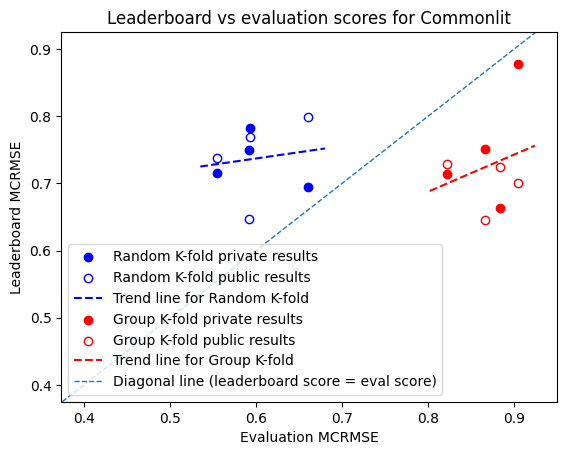

In [98]:
fold_private_leaderboards = [0.75, 0.783, 0.695, 0.716]
fold_public_leaderboards = [0.647, 0.769, 0.798, 0.738]
fold_eval = [0.5919, 0.59318, 0.66, 0.55525]

group_private_leaderboards = [0.877, 0.664, 0.714, 0.751]
group_public_leaderboards = [0.701, 0.724, 0.729, 0.645]
group_eval = [0.9037, 0.8836, 0.8218, 0.86589]


plt.scatter(fold_eval, fold_private_leaderboards, label="Random K-fold private results", marker='o', c='blue')
plt.scatter(fold_eval, fold_public_leaderboards, label="Random K-fold public results", marker='o', c='white', edgecolors='blue')

# Trend line
z = np.polyfit(fold_eval + fold_eval, fold_private_leaderboards + fold_public_leaderboards, 1)
poly_fold = np.poly1d(z)
trend_x_fold = [min(fold_eval) - 0.02, max(fold_eval) + 0.02]
plt.plot(trend_x_fold, poly_fold(trend_x_fold), c='blue', linestyle="--", label="Trend line for Random K-fold")

plt.scatter(group_eval, group_private_leaderboards, label="Group K-fold private results", marker='o', c='red')
plt.scatter(group_eval, group_public_leaderboards, label="Group K-fold public results", marker='o', c='white', edgecolors='red')

# Trend line for group K-fold
z = np.polyfit(group_eval + group_eval, group_private_leaderboards + group_public_leaderboards, 1)
poly_group = np.poly1d(z)
trend_x_group = [min(group_eval) - 0.02, max(group_eval) + 0.02]
plt.plot(trend_x_group, poly_group(trend_x_group), c='red', linestyle="--", label="Trend line for Group K-fold")

plt.xlabel("Evaluation MCRMSE")
plt.ylabel("Leaderboard MCRMSE")
plt.title("Leaderboard vs evaluation scores for Commonlit")

plt.axline((0.4, 0.4), (0.9, 0.9), linestyle="--", linewidth=1, label="Diagonal line (leaderboard score = eval score)")

plt.legend()

plt.show()

Results here are pretty interesting. It comes up, that:

- `Group K-fold` constantly underestimates it classifiers while `Random K-fold` constatly overestimates them.
- The mean leaderboard score of tuned on `Group K-fold` is less than the mean leaderboard score of tuned on `Random K-fold`. _But it doesn't look like a statistically significant result._
- `Group K-fold`'s trend line is closer to diagonal by its angle, meaning that `Group K-fold` eval correlates with leaderboard score more. But both graphs aren't aligned in a good way. They have a huge variance across the trend line. Looks like a `Group K-fold` has an outlier that determines the arrangment of the trend line.

#### Correlations between leaderboard and evaluation

Let's also watch some correlation info and mean leaderboard score difference, assuming significance level of 0.05:

In [106]:
print("Random K-fold correlation test")

fold_pearson = pearsonr(fold_private_leaderboards + fold_public_leaderboards, fold_eval * 2)
fold_spearman = spearmanr(fold_private_leaderboards + fold_public_leaderboards, fold_eval * 2)

pd.DataFrame({"Pearson": [fold_pearson.statistic, fold_pearson.pvalue], "Spearman": [fold_spearman.statistic, fold_spearman.pvalue]},
            index=["Correlation coefficient", "P value"])

Random K-fold correlation test


,Pearson,Spearman
Correlation coefficient,0.151088,0.39036
P value,0.720992,0.33903


In [109]:
print("Group K-fold correlation test")

group_pearson = pearsonr(group_private_leaderboards + group_public_leaderboards, group_eval * 2)
group_spearman = spearmanr(group_private_leaderboards + group_public_leaderboards, group_eval * 2)

pd.DataFrame({"Pearson": [group_pearson.statistic, group_pearson.pvalue], "Spearman": [group_spearman.statistic, group_spearman.pvalue]},
            index=["Correlation coefficient", "P value"])

Group K-fold correlation test


,Pearson,Spearman
Correlation coefficient,0.253752,0.048795
P value,0.544244,0.908654


All the correlations are positive. Pearson correlation for `Group K-fold` is bigger, but Spearman correlation is significantly bigger for `Random K-fold` (however, with medium p-value). Spearman correlation for the `Group K-fold` is almost zero. Interesting results that show that the difference between evaluation methods aren't very significant.

#### Statistical tests on distributions

Now let's warch on leaderboard distribution's difference.

**Leaderboard scores comparison**

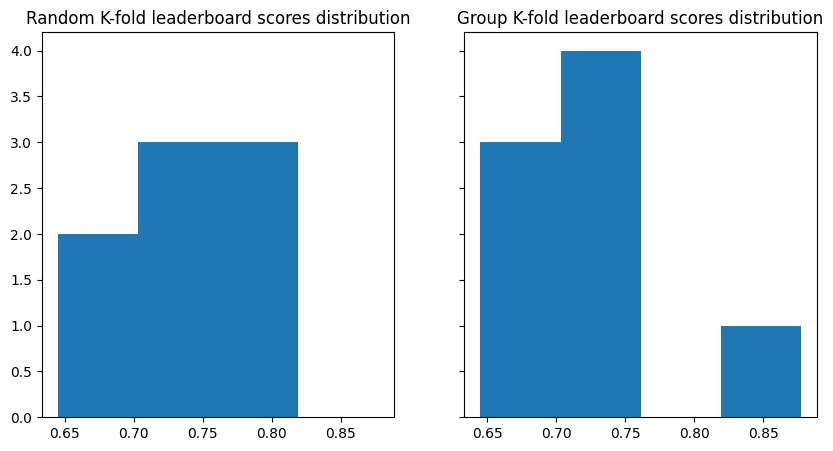

In [138]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

global_min = min(fold_private_leaderboards + fold_public_leaderboards + group_private_leaderboards + group_public_leaderboards)
global_max = max(fold_private_leaderboards + fold_public_leaderboards + group_private_leaderboards + group_public_leaderboards)

axs[0].hist(fold_private_leaderboards + fold_public_leaderboards, bins=4, range=[global_min, global_max])
axs[1].hist(group_private_leaderboards + group_public_leaderboards, bins=4, range=[global_min, global_max])

axs[0].set_title("Random K-fold leaderboard scores distribution")
axs[1].set_title("Group K-fold leaderboard scores distribution")

plt.show()

Variance inequality test:

In [121]:
levene(fold_private_leaderboards + fold_public_leaderboards, group_private_leaderboards + group_public_leaderboards)

LeveneResult(statistic=0.09750425214342677, pvalue=0.7594477885480175)

p-value is bigger than alpha, so we can't assume that H1 is right (variances are different).

In [119]:
ttest_ind(a=fold_private_leaderboards + fold_public_leaderboards, b=group_private_leaderboards + group_public_leaderboards, equal_var=True)

TtestResult(statistic=0.37347499095107695, pvalue=0.7143895415787043, df=14.0)

p-value here is much bigger than the chosen significance level, so we can't reject the null hypothesis of the equality of means.

That means that the results of both evaluation methods for tuning may come from the same distribution on the leaderboard, there are no significant difference between the tunuing results.

**Random K-fold leaderboard and eval scores comparison**

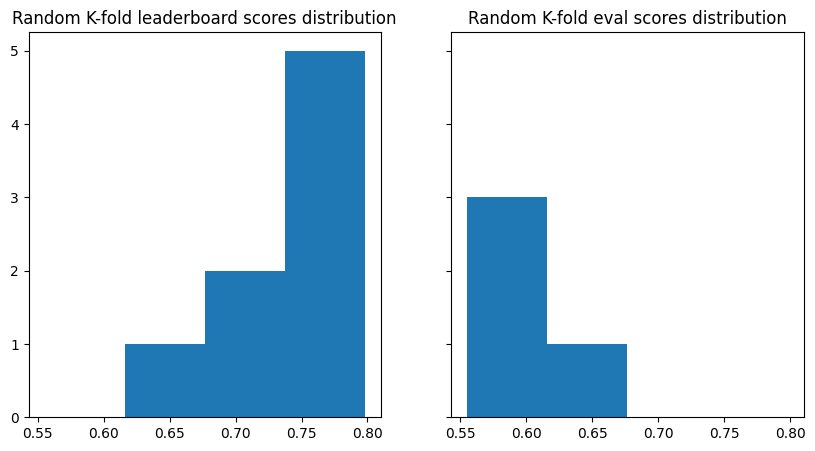

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

global_min = min(fold_private_leaderboards + fold_public_leaderboards + fold_eval)
global_max = max(fold_private_leaderboards + fold_public_leaderboards + fold_eval)

axs[0].hist(fold_private_leaderboards + fold_public_leaderboards, bins=4, range=[global_min, global_max])
axs[1].hist(fold_eval, bins=4, range=[global_min, global_max])

axs[0].set_title("Random K-fold leaderboard scores distribution")
axs[1].set_title("Random K-fold eval scores distribution")

plt.show()

In [140]:
levene(fold_private_leaderboards + fold_public_leaderboards, fold_eval)

LeveneResult(statistic=0.37840676753187524, pvalue=0.5521977823001033)

p-value is bigger than alpha, so we can't assume that H1 is right (variances are different).

In [141]:
ttest_ind(a=fold_private_leaderboards + fold_public_leaderboards, b=fold_eval, equal_var=True)

TtestResult(statistic=4.65695097780173, pvalue=0.0008984770601700977, df=10.0)

p-value here is smaller than the chosen significance level, so we can reject the null hypothesis of the equality of means.

That means that the results leaderboard score distribution has different mean than the eval for the `Random K-fold`. In this case, it is obviously bigger in mean.

**Group K-fold leaderboard and eval scores comparison**

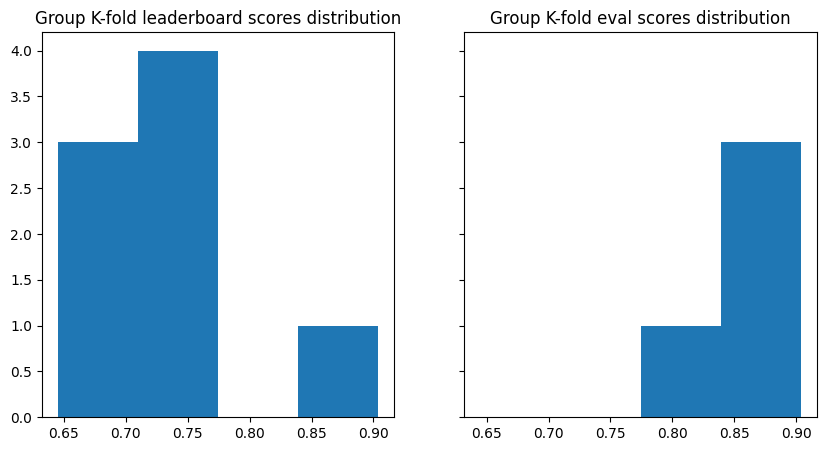

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

global_min = min(group_private_leaderboards + group_public_leaderboards + group_eval)
global_max = max(group_private_leaderboards + group_public_leaderboards + group_eval)

axs[0].hist(group_private_leaderboards + group_public_leaderboards, bins=4, range=[global_min, global_max])
axs[1].hist(group_eval, bins=4, range=[global_min, global_max])

axs[0].set_title("Group K-fold leaderboard scores distribution")
axs[1].set_title("Group K-fold eval scores distribution")

plt.show()

In [145]:
levene(group_private_leaderboards + group_public_leaderboards, group_eval)

LeveneResult(statistic=0.5097228900223635, pvalue=0.4915864349611446)

p-value is bigger than alpha, so we can't assume that H1 is right (variances are different).

In [146]:
ttest_ind(a=group_private_leaderboards + group_public_leaderboards, b=group_eval, equal_var=True)

TtestResult(statistic=-3.7781881199056278, pvalue=0.0036126785224621983, df=10.0)

p-value here is smaller than the chosen significance level, so we can reject the null hypothesis of the equality of means.

That means that the results leaderboard score distribution has different mean than the eval for the `Group K-fold` method. In this case, leaderboard scores are obviously smaller in mean. 

### Conclusion

Given plots and statistical tests, it seems that both evaluation methods are valid and correlate with the final result in the same way.
It would be great to have bigger number of models compared for more statistical significancy.

So, a `Random K-fold` performs the same way as a `Group K-fold` does. Logically, it shouldn't be the case because there are other prompts (groups) used on the leaderboard. Still, there can be some leakage in a form of students who have their essays both in the training and testing set.

Both approaches correlate with the leaderboard, but with quite a weak correlation. 

In a real-world scenario, on production, I would have definitely chosen the `Group K-fold` approach:
- It simply has a stronger assumption. `Random K-fold` checks the model's ability to remember good answers to existing questions, while the `Group K-fold` allows it to check its generalization ability. So, it is much more helpful if the model can work with basically every data in the given format, not just very close to the training. 
- In this case, it was also shown that this approach is the one that underestimates the metrics. It is better to have metrics underestimated than overestimated.